In [1]:
%run radiomorpho.py

In [2]:
dirs = ('101first_fit', '101nvss_fit')
files = transpose_mtx([get_file_list(dirs[i], 'fit') for i in range(len(dirs))])

In [3]:
%%time
sz = 10
dt = []
names = []
for im in files:
    try:
        dat = np.append(
                get_open_close_info(readNormalizedImg(im[0]), sz), 
                get_open_close_info(readNormalizedImg(im[1]), sz)
              )
        dt.append(dat)
        names.append(im)
        pass
    except OSError:
        pass
files = names

CPU times: user 54.7 s, sys: 63.6 ms, total: 54.8 s
Wall time: 54.9 s


In [4]:
dt = np.array(dt)
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(dt)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [5]:
Y = pca.transform(dt)
xs, ys = Y[:,0] , Y[:,1]

In [6]:
# from sklearn.manifold import TSNE
# dt_e = TSNE(n_components=2).fit_transform(dt)
# xs, ys = dt_e[:,0], dt_e[:,1]

<IPython.core.display.Javascript object>


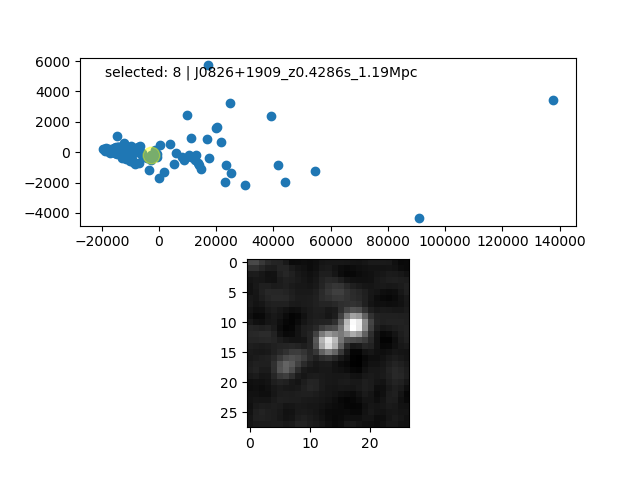

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
class DataBrowser(object):
    """
    Click on a point to select and highlight it -- the data that
    generated the point will be shown in the lower axes.  Use the 'n'
    and 'p' keys to browse through the next and previous points
    """

    def __init__(self, fig, ax1, ax2, xs, ys):
        self.lastind = 0

        self.text = ax1.text(0.05, 0.95, 'selected: none',
                            transform=ax1.transAxes, va='top')
        self.selected, = ax1.plot([xs[0]], [ys[0]], 'o', ms=12, alpha=0.4,
                                 color='yellow', visible=False)
        self.xs = xs
        self.ys = ys
        self.fit = fig

        self.ax2 = ax2

    def onpress(self, event):
        if self.lastind is None:
            return
        if event.key not in ('n', 'p'):
            return
        if event.key == 'n':
            inc = 1
        else:
            inc = -1

        self.lastind += inc
        self.lastind = np.clip(self.lastind, 0, len(self.xs) - 1)
        self.update()

    def onpick(self, event):

        if event.artist != line:
            return True

        N = len(event.ind)
        if not N:
            return True

        # the click locations
        x = event.mouseevent.xdata
        y = event.mouseevent.ydata

        distances = np.hypot(x - self.xs[event.ind], y - self.ys[event.ind])
        indmin = distances.argmin()
        dataind = event.ind[indmin]

        self.lastind = dataind
        self.update()

    def update(self):
        if self.lastind is None:
            return

        dataind = self.lastind

        img = readNormalizedImg(files[dataind][1])
        self.ax2.cla()
        self.ax2.imshow(img, cmap='gray')

        self.selected.set_visible(True)
        self.selected.set_data(self.xs[dataind], self.ys[dataind])

        self.text.set_text('selected: {0} | {1}'.format(dataind,
            '.'.join(files[dataind][0].split('/')[1].split('.')[:-2])))
        self.fig.canvas.draw()

fig, (ax, ax2) = plt.subplots(2, 1)
line, = ax.plot(xs, ys, 'o', picker=5)
browser = DataBrowser(fig, ax, ax2, xs, ys)
fig.canvas.mpl_connect('pick_event', browser.onpick)
fig.canvas.mpl_connect('key_press_event', browser.onpress)
plt.show()

In [15]:
index = 66
im1 = readNormalizedImg(names[index][0])
im2 = readNormalizedImg(names[index][1])

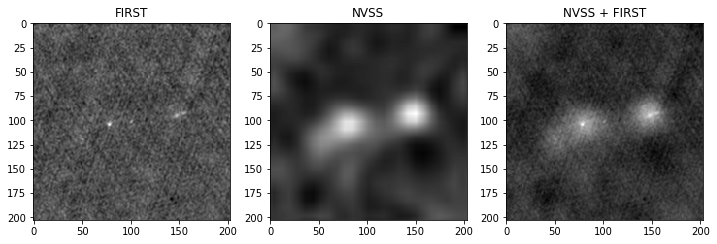

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
scale_fac = (im1.shape[0]/im2.shape[0] , im1.shape[1]/im2.shape[1])
im2_r = sk.transform.rescale(im2, scale_fac, mode='reflect')
im3 = im1 + im2_r
f, ax = plt.subplots(1, 3, figsize=(12,15))
ax[0].set_title('FIRST')
ax[0].imshow(im1, cmap='gray')
ax[1].set_title('NVSS')
ax[1].imshow(im2_r, cmap='gray')
ax[2].set_title('NVSS + FIRST')
ax[2].imshow(im3, cmap='gray')
plt.show()

/home/jperalta/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


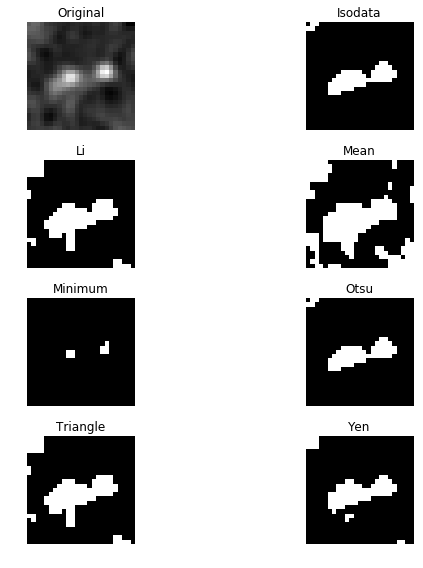

In [20]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import try_all_threshold

img = data.page()

fig, ax = try_all_threshold(im2, figsize=(10, 8), verbose=False)
plt.show()

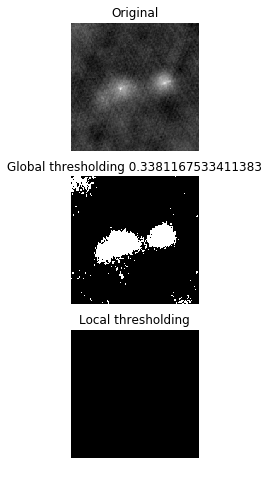

In [33]:
from skimage.filters import threshold_otsu, threshold_local
image = im3 / 2
# image = im2
global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 55
local_thresh = threshold_local(image, block_size, offset=10)
binary_local = image > local_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding {}'.format(global_thresh))

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

In [30]:
im3.max()

1.8751648882200886